# Modelos preditivos de queimadas no Brasil

- <a href='#l1'>Introdução</a>
- <a href='#l2'>Coleta de Dados</a>
- <a href='#l3'>Processamento/Tratamento de Dados</a>
- <a href='#l4'>Análise Exploratória de Dados</a>
- <a href='#l5'>Preparação de dados para o modelo</a>

<a id='l1'></a>

---

## Introdução

O tema da preservação do meio ambiente está desde sempre presente no nosso dia a dia, e é um tema cada vez mais importante, dada a constante exploração da natureza e suas consequências que ameaçam a sobrevivência da própria espécie humana. 

As queimadas são uns dos principais problemas, que pelo menos no Brasil, (ainda) são consideradas crimes contra a natureza, se não feitas com licença do orgão ambiental competente.

As queimadas devastam áreas inteiras de vegetação, matam e expulsam a fauna, prejudicam o solo, emitem gases poluentes e fumaça que fazem mal à saúde dos animais (humanos inclusos), além de aumentar a temperatura como um todo, contribuindo para o famigerado aquecimento global e efeito estufa.

Existem dois fatores principais para as queimadas: o natural e o humano. No primeiro, se deve a incidência de descargas elétricas em áreas de pastagens, e também atividades vulcânicas. No segundo caso, são provocadas pelo ação humana, deliberada ou não, como queimadas para limpeza, balões, bitucas de cigarro, entre outras causas.

Para quem pratica a atividade agropecuária, é comum que nas épocas de maior seca, seja aproveitado para executar as tais limpezas no solo para o plantio. No caso de países com uma economia desindustrializada e dependente da exportação de commodities agrícolas, há um aumento constante dessas atividades, e com isso uma expansão cada vez maior das fronteiras agrícolas. Para que isso possa ocorrer, taca-se fogo em tudo o que há pela frente, de forma criminosa, em hectares e mais hectares de natureza.

Uma das soluções passa nas opções que o país faz, em investir tão pouco numa econômia industrial, e tanto na exportação de produtos vindos da agropecuária. Outra solução _ que não resolve _ é o da exploração responsável, onde nesse caso são adotados sistemas de monitoramento e fiscalicação eficientes por parte do poder público, e leis severas que punem de fato quem faz os chamados desmatamentos ilegais. A questão é o que o país entende por desmatamento ilegal. Achar que apenas agir dentro da lei não é suficiente, no sentido de proteger o meio ambiente, se tais leis continuarem a ser tão permissivas.

Seja como for, há de pelo menos começarmos a fazer o mínimo, e ir elevando a consciência popular para as questões do meio ambiente.

Neste relatório técnico, o objetivo é através de algoritmos, criar previsões de queimadas.

<a id='l2'></a>

---

## Coleta de Dados

Os dados desta análise foram coletados a partir do Portal Queimadas do INPE (Instituto Nacional de Pesquisas Espaciais). Foram feitas extrações do período de 8 anos, ou seja, entre janeiro de 2015 e junho de 2022. A escolha desse período se deu pela completude dos dados no portal, valores de risco fogo, frp, dias sem chuva, por exemplo, não eram coletados previamente a esse período.

Os filtros utilizados foram:

- Continentes: América do Sul
- Países: Brasil
- Estados: Todos os estados
- Data Início: 01/01/ano
- Data Fim: 31/12/ano
- Satélites: Satélite de referência (Aqua Tarde)
- Biomas: Todos
- Formato de exportação: CSV

Satélite:

- Aqua: https://www.embrapa.br/satelites-de-monitoramento/missoes/aqua
- Sensor MODIS: https://mundogeo.com/2004/05/23/o-sensor-modis-a-bordo-das-plataformas-terra-e-acqua/

Temperaturas:
- INMET: https://portal.inmet.gov.br/normais

In [108]:
# Bibliotecas

import pandas as pd
import numpy as np
import json
from scipy import stats

import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)

%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

from datetime import datetime, timezone, timedelta, time, date

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR')
import calendar

from os.path import exists

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()

%load_ext autoreload
%autoreload 2

from Funcoes import Funcoes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='l3'></a>

---

## Processamento/Tratamento de Dados

Como o portal limita a coleta de dados a no máximo 1 ano, foram feitas coletas anuais de dados. Portanto, há a necessidade de unir todos os arquivos csv num único.

Mas esse processo não precisa ser repetido sempre. Na primeira execução do projeto ele verifica se o arquivo concatenado foi criado, se não o cria.

In [2]:
# importar dados

arquivo_csv = 'dados/focos_queimadas.csv'

if not exists(arquivo_csv):
    Funcoes.unir_arquivos()
    
df_focos_queimadas = pd.read_csv(arquivo_csv, sep=',', encoding='latin 1')

In [3]:
df_focos_queimadas.head()

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,2015/11/07 16:30:00,AQUA_M-T,Brasil,PARA,PORTEL,Amazonia,4.0,0.1,0.6,-2.245,-50.667,NaN
1,2015/04/02 16:46:00,AQUA_M-T,Brasil,TOCANTINS,PEIXE,Cerrado,1.0,0.1,0.3,-11.994,-48.548,NaN
2,2015/03/23 17:47:00,AQUA_M-T,Brasil,MATO GROSSO,FELIZ NATAL,Amazonia,3.0,0.4,0.2,-12.185,-54.405,NaN
3,2015/02/21 17:39:00,AQUA_M-T,Brasil,RORAIMA,IRACEMA,Amazonia,20.0,0.0,1.0,2.247,-61.527,NaN
4,2015/08/02 17:25:00,AQUA_M-T,Brasil,PARA,ORIXIMINA,Amazonia,0.0,0.1,0.8,-1.754,-55.686,NaN


In [4]:
df_focos_queimadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368553 entries, 0 to 1368552
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   datahora      1368553 non-null  object 
 1   satelite      1368553 non-null  object 
 2   pais          1368553 non-null  object 
 3   estado        1368553 non-null  object 
 4   municipio     1368553 non-null  object 
 5   bioma         1368553 non-null  object 
 6   diasemchuva   1367223 non-null  float64
 7   precipitacao  1367223 non-null  float64
 8   riscofogo     1367223 non-null  float64
 9   latitude      1368553 non-null  float64
 10  longitude     1368553 non-null  float64
 11  frp           757417 non-null   float64
dtypes: float64(6), object(6)
memory usage: 125.3+ MB


De cara é possível perceber que existem dados faltantes para `diasemchuva`, `precipitacao`, `riscofogo` e principalmente `frp`. Depois será necessário verificar como proceder nestes casos.

In [5]:
df_focos_queimadas.describe()

,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
count,1.367223e+06,1.367223e+06,1.367223e+06,1.368553e+06,1.368553e+06,757417.000000
mean,9.504688e+00,7.087691e-01,-4.706983e+00,-1.031434e+01,-5.207692e+01,62.193874
std,8.999016e+01,2.981452e+00,7.363247e+01,6.385679e+00,7.709857e+00,139.726603
min,-9.990000e+02,0.000000e+00,-9.990000e+02,-3.370900e+01,-7.367366e+01,0.000000
25%,1.000000e+00,0.000000e+00,5.000000e-01,-1.364400e+01,-5.704700e+01,15.000000
50%,5.000000e+00,0.000000e+00,1.000000e+00,-9.390000e+00,-5.101300e+01,28.200000
75%,1.700000e+01,1.000000e-01,1.000000e+00,-6.033000e+00,-4.605900e+01,59.000000
max,8.270000e+02,1.430000e+02,1.000000e+00,5.154000e+00,-3.481600e+01,9612.200000


Das colunas que temos, vamos trabalhar com as seguintes:

- **datahora**: Horário de referência da passagem do satélite segundo o fuso horário de Greenwich (GMT);
- **satelite**: Nome do algoritmo utilizado e referência ao satélite provedor da imagem;
- **pais**: Nome do país;
- **estado**: Nome da unidade federativa;
- **municipio**: Nome do município. Para o Brasil foi utilizado como referência o dado do IBGE 2000;
- **bioma** uma unidade biológica ou espaço geográfico cujas características específicas são definidas pelo macroclima, o solo, a altitude, dentre outros critérios;
- **diasemchuva**: Número de dias sem chuva até a detecção do foco;
- **precipitacao**: Valor da precipitação acumulada no dia até o momento da detecção do foco (milímetros por dia);
- **riscofogo**: Valor do Risco de Fogo previsto para o dia da detecção do foco (Vai de 0 até 1, e o valor 777.7 significa que é valor inválido);
- **latitude**: Latitude do foco do incêndio 
- **longitude**: Longitude do foco do incêndio
- **frp**: Fire Radiative Power (Energia Radiativa do Fogo, intensidade da queimada), valor em MW (megawatts).

### Tratar dados

Excluir colunas indesejadas e procurar por valores nulos e faltantes.

In [6]:
df_focos_queimadas.drop(['satelite', 'pais'], axis=1, inplace=True)
df_focos_queimadas.describe()

,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
count,1.367223e+06,1.367223e+06,1.367223e+06,1.368553e+06,1.368553e+06,757417.000000
mean,9.504688e+00,7.087691e-01,-4.706983e+00,-1.031434e+01,-5.207692e+01,62.193874
std,8.999016e+01,2.981452e+00,7.363247e+01,6.385679e+00,7.709857e+00,139.726603
min,-9.990000e+02,0.000000e+00,-9.990000e+02,-3.370900e+01,-7.367366e+01,0.000000
25%,1.000000e+00,0.000000e+00,5.000000e-01,-1.364400e+01,-5.704700e+01,15.000000
50%,5.000000e+00,0.000000e+00,1.000000e+00,-9.390000e+00,-5.101300e+01,28.200000
75%,1.700000e+01,1.000000e-01,1.000000e+00,-6.033000e+00,-4.605900e+01,59.000000
max,8.270000e+02,1.430000e+02,1.000000e+00,5.154000e+00,-3.481600e+01,9612.200000


Encontrado vazios (NA) nas colunas diasemchuva, precipitacao, riscofogo e frp.

In [7]:
df_focos_queimadas.isna().sum()

datahora             0
estado               0
municipio            0
bioma                0
diasemchuva       1330
precipitacao      1330
riscofogo         1330
latitude             0
longitude            0
frp             611136
dtype: int64

In [8]:
# diasemchuva, precipitacao, riscofogo

(1330 / df_focos_queimadas.size) * 100

0.009718293701449632

No caso das colunas que tem poucos valores vazios (menos de 1%), zerar estes valores não vai causar nenhum prejuízo.

In [9]:
# frp

(611136 / df_focos_queimadas.size) * 100

4.465563262803852

No caso do campo `frp`, os dados vazios são cerca de 4% do dataset, mas numa das explicações sobre a coleta de dados dos satélites, este valor nem sempre consegue ser medido, porque pode ter sido uma queimada de baixa intensidade, então ele será mantidado tal como veio.

In [10]:
# Zerando os valores riscofogo, diasemchuva, precipitacao quando vazios

df_focos_queimadas.loc[df_focos_queimadas.diasemchuva.isna(), 'diasemchuva'] = 0
df_focos_queimadas.loc[df_focos_queimadas.precipitacao.isna(), 'precipitacao'] = 0
df_focos_queimadas.loc[df_focos_queimadas.riscofogo.isna(), 'riscofogo'] = 0

In [11]:
# conferindo

df_focos_queimadas.isna().sum()

datahora             0
estado               0
municipio            0
bioma                0
diasemchuva          0
precipitacao         0
riscofogo            0
latitude             0
longitude            0
frp             611136
dtype: int64

**Converter nome dos estados em UF**

Para isso, foi criado um arquivo json, chave-valor, e o objetivo é substituir os nomes dos estados pelas suas UFs, para facilitar a visualização das informações no gráfico, quando houver necessidade de mostrá-los.

In [12]:
with open('dados/estados_map.json', encoding='utf-8') as json_file:
    estados_map = json.load(json_file)

estados_map

{'ACRE': 'AC',
 'ALAGOAS': 'AL',
 'AMAPA': 'AP',
 'AMAZONAS': 'AM',
 'BAHIA': 'BA',
 'CEARA': 'CE',
 'DISTRITO FEDERAL': 'DF',
 'ESPIRITO SANTO': 'ES',
 'GOIAS': 'GO',
 'MARANHAO': 'MA',
 'MATO GROSSO': 'MT',
 'MATO GROSSO DO SUL': 'MS',
 'MINAS GERAIS': 'MG',
 'PARA': 'PA',
 'PARAIBA': 'PB',
 'PARANA': 'PR',
 'PERNAMBUCO': 'PE',
 'PIAUI': 'PI',
 'RIO DE JANEIRO': 'RJ',
 'RIO GRANDE DO NORTE': 'RN',
 'RIO GRANDE DO SUL': 'RS',
 'RONDONIA': 'RO',
 'RORAIMA': 'RR',
 'SERGIPE': 'SE',
 'SANTA CATARINA': 'SC',
 'SAO PAULO': 'SP',
 'TOCANTINS': 'TO'}

In [13]:
df_focos_queimadas = df_focos_queimadas.replace({'estado': estados_map})

**Trabalhando com as datas**

Primeiro, se sabe que o fuso horário dos satélites é o GMT (UTC). Como a análise será feita numa região específica do globo, no caso o Brasil, pode-se converter o fuso do campo datahora para o de Brasília (-3 horas em relação ao GMT) que é o considerado o oficial brasileiro.

In [14]:
# Converter a datahora para um objeto data

df_focos_queimadas['datahora'] = pd.to_datetime(df_focos_queimadas['datahora'], errors='coerce')

# Converter o objeto datahora para o fuso de SP (que é igual o de Brasilia)

df_focos_queimadas['datahora_tz'] = df_focos_queimadas.apply(Funcoes.converter_fuso, axis=1)

In [15]:
# Converter a datahora com fuso de Brasília, para um objeto data

df_focos_queimadas['datahora_tz'] = pd.to_datetime(df_focos_queimadas['datahora_tz'], errors='coerce')

Depois será necessário separar data e hora, para facilitar trabalhar com ambos.

In [16]:
# Separar a data e e hora em colunas diferentes

df_focos_queimadas['data'] = Funcoes.converter_data_hora(df_focos_queimadas, 'datahora_tz', 'data')
df_focos_queimadas['hora'] = Funcoes.converter_data_hora(df_focos_queimadas, 'datahora_tz', 'hora')

In [17]:
df_focos_queimadas['dia_semana'] = df_focos_queimadas['datahora_tz'].dt.weekday # Dia da semana
df_focos_queimadas['mes'] = df_focos_queimadas['datahora_tz'].dt.month # Mês do ano
df_focos_queimadas['ano'] = df_focos_queimadas['datahora_tz'].dt.year # ano

In [18]:
df_focos_queimadas.head(5)

,datahora,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,datahora_tz,data,hora,dia_semana,mes,ano
0,2015-11-07 16:30:00,PA,PORTEL,Amazonia,4.0,0.1,0.6,-2.245,-50.667,NaN,2015-11-07 14:30:00,2015-11-07,14:30:00,5,11,2015
1,2015-04-02 16:46:00,TO,PEIXE,Cerrado,1.0,0.1,0.3,-11.994,-48.548,NaN,2015-04-02 13:46:00,2015-04-02,13:46:00,3,4,2015
2,2015-03-23 17:47:00,MT,FELIZ NATAL,Amazonia,3.0,0.4,0.2,-12.185,-54.405,NaN,2015-03-23 14:47:00,2015-03-23,14:47:00,0,3,2015
3,2015-02-21 17:39:00,RR,IRACEMA,Amazonia,20.0,0.0,1.0,2.247,-61.527,NaN,2015-02-21 15:39:00,2015-02-21,15:39:00,5,2,2015
4,2015-08-02 17:25:00,PA,ORIXIMINA,Amazonia,0.0,0.1,0.8,-1.754,-55.686,NaN,2015-08-02 14:25:00,2015-08-02,14:25:00,6,8,2015


**Risco fogo**

Vamos adicionar a coluna `riscofogo_nivel` para classificar os níveis do risco de fogo, que o próprio instituto utiliza: 

- Mínimo: abaixo de 0,15; 
- Baixo: de 0,15 a 0,4; 
- Médio: de 0,4 a 0,7; 
- Alto: de 0,7 a 0,95 ; 
- Crítico: acima de 0,95 até 1.

In [19]:
df_focos_queimadas['riscofogo_nivel'] = df_focos_queimadas.apply(Funcoes.classificar_risco_fogo, axis=1)

Vamos adicionar a coluna `riscofogo_categoria` para fazer uma classificação binária

- Abaixo de 0,7: 0 (Mínimo, Baixo, Médio)
- Acima de 0,7: 1 (Alto, Crítico)


In [20]:
df_focos_queimadas['riscofogo_categoria'] = df_focos_queimadas.apply(Funcoes.categorizar_risco_fogo, axis=1)

**Dias sem chuva**

Por alguma razão, existem valores negativos no campo `diasemchuva`, então será colocado um valor zero nestas colunas.

In [21]:
df_focos_queimadas.loc[df_focos_queimadas['diasemchuva'] < 0, ['diasemchuva']] = 0

<a id='l4'></a>

---

## Análise Exploratória de Dados

Vamos iniciar as análises das diferentes variáveis do dataframe.

In [22]:
df_focos_queimadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368553 entries, 0 to 1368552
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   datahora             1368553 non-null  datetime64[ns]
 1   estado               1368553 non-null  object        
 2   municipio            1368553 non-null  object        
 3   bioma                1368553 non-null  object        
 4   diasemchuva          1368553 non-null  float64       
 5   precipitacao         1368553 non-null  float64       
 6   riscofogo            1368553 non-null  float64       
 7   latitude             1368553 non-null  float64       
 8   longitude            1368553 non-null  float64       
 9   frp                  757417 non-null   float64       
 10  datahora_tz          1368553 non-null  datetime64[ns]
 11  data                 1368553 non-null  object        
 12  hora                 1368553 non-null  object        
 1

In [23]:
df_focos_queimadas.describe()

,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,dia_semana,mes,ano,riscofogo_categoria
count,1.368553e+06,1.368553e+06,1.368553e+06,1.368553e+06,1.368553e+06,757417.000000,1.368553e+06,1.368553e+06,1.368553e+06,1.368553e+06
mean,1.654694e+01,7.080802e-01,-4.702408e+00,-1.031434e+01,-5.207692e+01,62.193874,3.003469e+00,8.492683e+00,2.018044e+03,6.927054e-01
std,2.936601e+01,2.980084e+00,7.359683e+01,6.385679e+00,7.709857e+00,139.726603,1.971517e+00,2.180710e+00,2.094026e+00,4.613727e-01
min,0.000000e+00,0.000000e+00,-9.990000e+02,-3.370900e+01,-7.367366e+01,0.000000,0.000000e+00,1.000000e+00,2.015000e+03,0.000000e+00
25%,1.000000e+00,0.000000e+00,5.000000e-01,-1.364400e+01,-5.704700e+01,15.000000,1.000000e+00,8.000000e+00,2.016000e+03,0.000000e+00
50%,5.000000e+00,0.000000e+00,1.000000e+00,-9.390000e+00,-5.101300e+01,28.200000,3.000000e+00,9.000000e+00,2.018000e+03,1.000000e+00
75%,1.700000e+01,1.000000e-01,1.000000e+00,-6.033000e+00,-4.605900e+01,59.000000,5.000000e+00,1.000000e+01,2.020000e+03,1.000000e+00
max,8.270000e+02,1.430000e+02,1.000000e+00,5.154000e+00,-3.481600e+01,9612.200000,6.000000e+00,1.200000e+01,2.022000e+03,1.000000e+00


### Focos de queimadas: por ano

Vamos criar um dataframe com apenas as quantidades de focos por ano.

In [24]:
df_ano = df_focos_queimadas.groupby(['ano'], as_index = True)['datahora'].count().reset_index()
df_ano.rename(columns = {'datahora':'qtde_focos'}, inplace = True)
df_ano

,ano,qtde_focos
0,2015,216778
1,2016,184217
2,2017,207508
3,2018,132870
4,2019,197632
5,2020,222797
6,2021,184081
7,2022,22670


In [25]:
print('Média:', np.round(np.mean(df_ano['qtde_focos'])))

print('Mediana:', np.round(np.median(df_ano['qtde_focos'])))

print('Desvio padrão:', np.round(np.std(df_ano['qtde_focos'])))

Média: 171069.0
Mediana: 190924.0
Desvio padrão: 61869.0


O ano de 2022 não tem sua coleta feita completamente, e com isso possui cerca de 10% dos registros do ano com maior quantidade de focos (2020). Por conta dessa distorção, vamos retirar os registros do ano de 2022 da análise.

In [26]:
df_focos_queimadas = df_focos_queimadas.loc[df_focos_queimadas['ano'] < 2022]

In [27]:
df_ano = df_focos_queimadas.groupby(['ano'], as_index = True)['datahora'].count().reset_index()
df_ano.rename(columns = {'datahora':'qtde_focos'}, inplace = True)
df_ano

,ano,qtde_focos
0,2015,216778
1,2016,184217
2,2017,207508
3,2018,132870
4,2019,197632
5,2020,222797
6,2021,184081


In [28]:
print('Média:', np.round(np.mean(df_ano['qtde_focos'])))

print('Mediana:', np.round(np.median(df_ano['qtde_focos'])))

print('Desvio padrão:', np.round(np.std(df_ano['qtde_focos'])))

Média: 192269.0
Mediana: 197632.0
Desvio padrão: 27913.0


In [109]:
def plotar_grafico_linha(_df: any, _x: str, _y: str, titulo: str, y_label: str, x_label: str, imagem='padrao.png'):
    plt.subplots(figsize = (14, 6))
    ax = sns.lineplot(data=_df, x=_x, y=_y, marker='o')
    for x, y in zip(_df[_x], _df[_y]):
        plt.text(x = x, y = y, s = '{:.0f}'.format(y), color='red', fontsize=10, horizontalalignment='right', verticalalignment='center_baseline')
    plt.title(titulo, fontsize=16)
    plt.ylabel(y_label, fontsize=13)
    plt.xlabel(x_label, fontsize=13)
    plt.tight_layout();
    plt.savefig(f'dados/{imagem}', dpi=100)

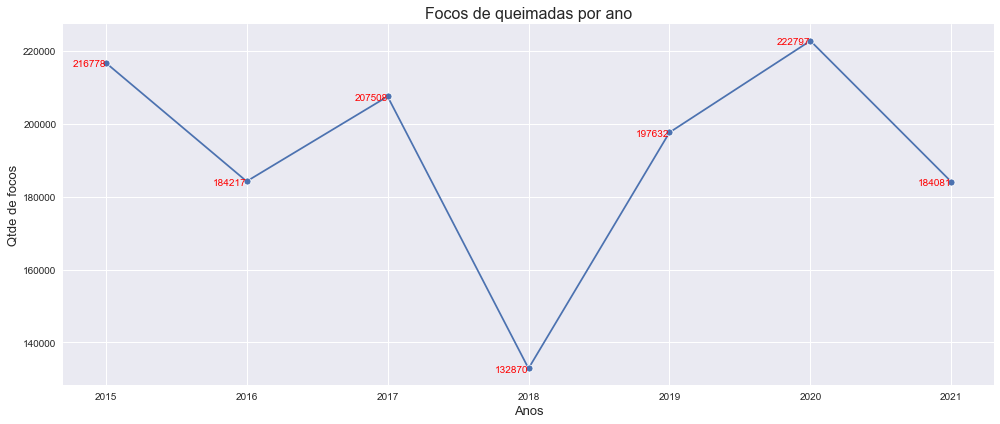

In [110]:
plotar_grafico_linha(df_ano, 'ano', 'qtde_focos', 'Focos de queimadas por ano', 'Qtde de focos', 'Anos')

**Comentário**: A média de focos por ano é 192.269 e o desvio padrão de 27.913, que é baixo, confirmando a proximidade dos valores, exceto pelos focos de 2018, que é o menor registro do período.

### Focos de queimadas: por mês

Vamos plotar os dados mês a mês para verificar se existe algum padrão que se repetes nos meses, independentemente do ano.

In [32]:
df_mes = df_focos_queimadas.groupby(['mes'], as_index = True)['datahora'].count().reset_index()
df_mes.rename(columns = {'datahora':'qtde_focos'}, inplace = True)

# Converter o número do mês em nome
df_mes['mes'] = df_mes['mes'].apply(lambda x: calendar.month_name[x].capitalize())
df_mes

,mes,qtde_focos
0,Janeiro,24212
1,Fevereiro,15688
2,Março,21255
3,Abril,18298
4,Maio,23646
5,Junho,44765
6,Julho,103186
7,Agosto,291465
8,Setembro,391486
9,Outubro,226148


In [33]:
print('Média:', np.round(np.mean(df_mes['qtde_focos'])))

print('Mediana:', np.round(np.median(df_mes['qtde_focos'])))

print('Desvio padrão:', np.round(np.std(df_mes['qtde_focos'])))

Média: 112157.0
Mediana: 53468.0
Desvio padrão: 119850.0


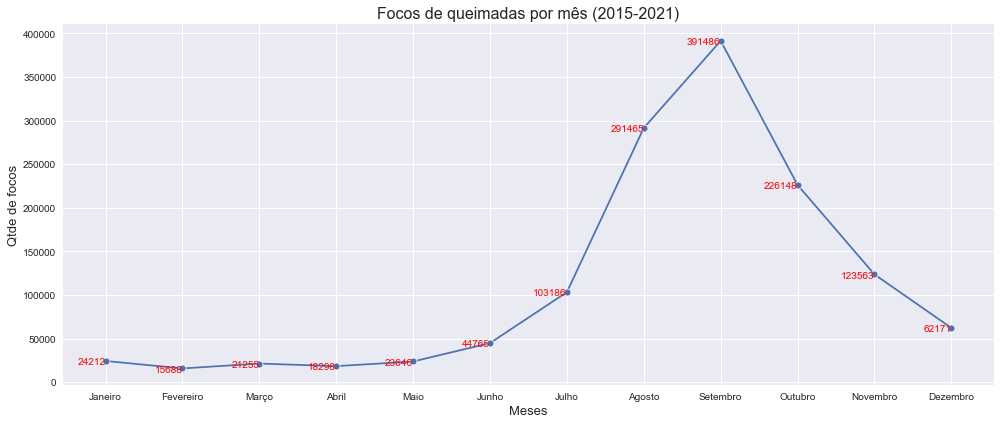

In [111]:
plotar_grafico_linha(df_mes, 'mes', 'qtde_focos', 'Focos de queimadas por mês (2015-2021)', 'Qtde de focos', 'Meses')

In [35]:
df_mesano = df_focos_queimadas.groupby(['ano', 'mes'], as_index = True)['datahora'].count().reset_index()
df_mesano.rename(columns = {'datahora':'qtde_focos'}, inplace = True)

df_mesano['mes_nome'] = df_mesano['mes'].apply(lambda x: calendar.month_name[x].capitalize())
df_mesano

,ano,mes,qtde_focos,mes_nome
0,2015,1,4313,Janeiro
1,2015,2,2026,Fevereiro
2,2015,3,1659,Março
3,2015,4,2024,Abril
4,2015,5,2169,Maio
...,...,...,...,...
79,2021,8,51711,Agosto
80,2021,9,49829,Setembro
81,2021,10,28342,Outubro
82,2021,11,11596,Novembro


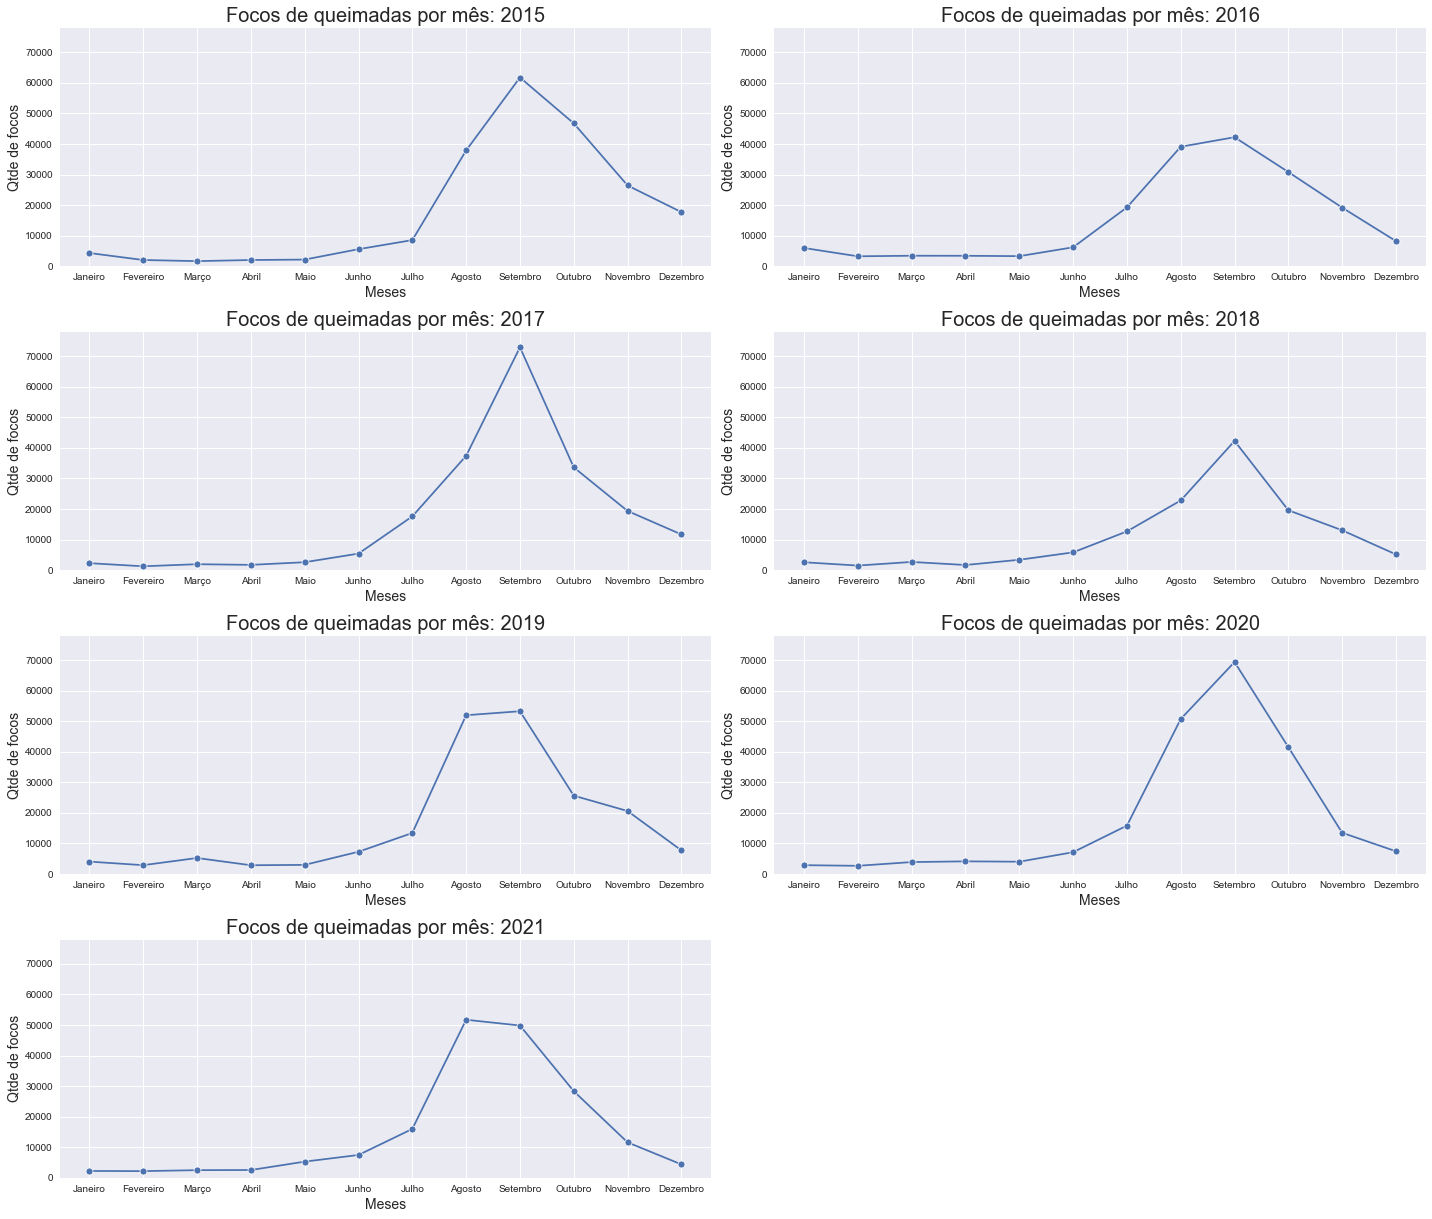

In [113]:
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,j in zip(range(1, len(df_mesano['ano'].unique())+1), df_mesano['ano'].unique()):
    _df = df_mesano[df_mesano['ano'] == j]
    plt.subplot(6, 2, i)
    ax = sns.lineplot(data=_df, x='mes_nome', y='qtde_focos', marker='o')
    ax.set_ylim([0, max(df_mesano['qtde_focos']) + 5000])
    plt.title('Focos de queimadas por mês: ' + str(j), fontsize=20)
    plt.ylabel('Qtde de focos', fontsize=14)
    plt.xlabel('Meses', fontsize=14)
    plt.tight_layout();
    plt.savefig(f'dados/focos_meses_por_ano.png', dpi=300);

**Comentário**: Olhando os gráficos ano a ano, é possível perceber um volume baixo de focos no primeiro semestre, e após esse período um aumento acelerado, atingindo o pico no mês de setembro (exceto em 2021, cujo pico foi em agosto) e finalmente uma queda mais acentuada de novembro para dezembro.

### Focos de queimadas: por estado

In [37]:
df_estado = df_focos_queimadas.groupby(['estado'], as_index = True)['datahora'].count().reset_index()
df_estado.rename(columns = {'datahora':'qtde_focos'}, inplace = True)

# Ordenar pelo maior número de focos
df_estado.sort_values(by=['qtde_focos'], ascending=False, inplace=True, ignore_index=True)

# criar coluna com qtde de focos relativa
df_estado['qtde_focos_relativa'] = np.round(df_estado['qtde_focos'] / sum(df_estado['qtde_focos']), 4) * 100

In [38]:
df_estado

,estado,qtde_focos,qtde_focos_relativa
0,PA,236382,17.56
1,MT,205386,15.26
2,MA,141108,10.48
3,AM,91976,6.83
4,TO,89630,6.66
5,RO,78560,5.84
6,PI,72186,5.36
7,BA,63872,4.75
8,MG,59828,4.45
9,MS,52217,3.88


In [39]:
print('Média:', np.round(np.mean(df_estado['qtde_focos'])))

print('Mediana:', np.round(np.median(df_estado['qtde_focos'])))

print('Desvio padrão:', np.round(np.std(df_estado['qtde_focos'])))

Média: 49848.0
Mediana: 26581.0
Desvio padrão: 59739.0


'\nplt.subplots(figsize = (14, 6))\nsns.barplot(data=df_estado, x=\'estado\', y=\'qtde_focos\', color="#3C9DD0")\nplt.title(\'Focos por estado\', fontsize=14)\nplt.ylabel(\'Qtde de focos\', fontsize=12)\nplt.xlabel(\'Estado\', fontsize=12)\nplt.tight_layout();\n'

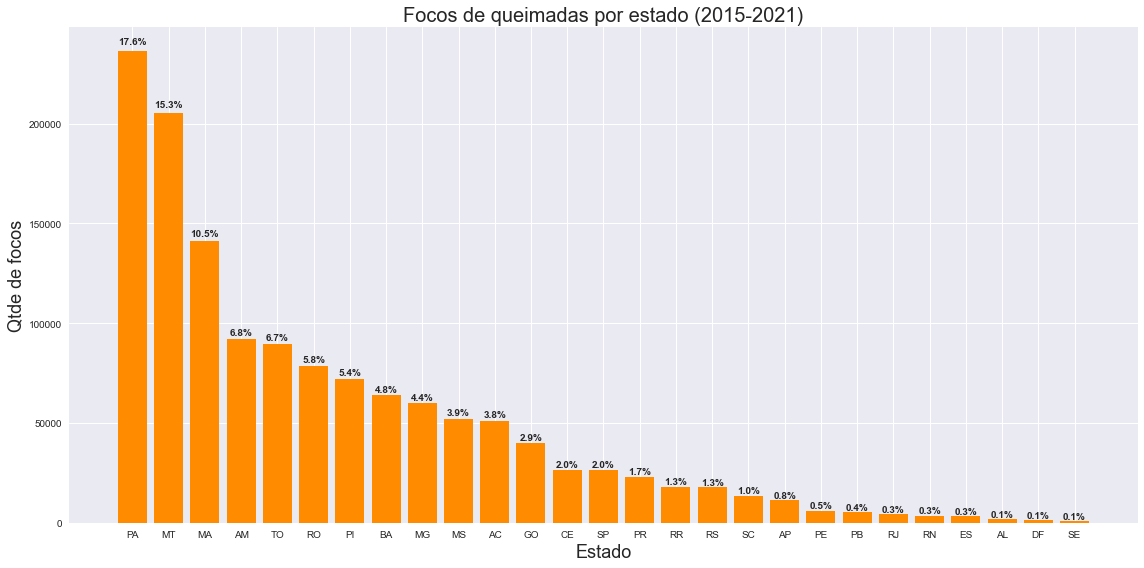

In [114]:
plt.figure(figsize=(16,8))
graph = plt.bar(df_estado.estado, df_estado.qtde_focos, color='darkorange')
plt.title('Focos de queimadas por estado (2015-2021)', fontsize=20)
plt.ylabel('Qtde de focos', fontsize=18)
plt.xlabel('Estado', fontsize=18)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+height*1.01, str(np.round(df_estado.qtde_focos_relativa[i],1))+'%', weight='bold', ha='center', va='bottom')
    i+=1
plt.tight_layout();
plt.savefig('dados/queimadas_estado.png', dpi=300);

Os sete estados com mais focos de queimadas são o Pará, Mato Grosso, Maranhão, Amazonas, Tocantins, Rondônia e Piauí. Todos estes estados cobertos pelos biomas da amazônia e do cerrado. Os estados mais ao litoral, em sua maioria, são os menos afetados pelos focos de queimadas _ mas também são estados com um território menor.

### Focos de queimadas: por bioma

Segundoo o IBGE: Bioma é um conjunto de vida vegetal e animal, constituído pelo agrupamento de tipos de vegetação que são próximos e que podem ser identificados em nível regional, com condições de geologia e clima semelhantes e que, historicamente, sofreram os mesmos processos de formação da paisagem, resultando em uma diversidade de flora e fauna própria.Em nosso país podemos encontrar seis tipos de biomas: **Amazônia, Mata Atlântica, Cerrado, Caatinga, Pampa e Pantanal**. 

In [41]:
df_bioma = df_focos_queimadas.groupby(['bioma'], as_index = True)['datahora'].count().reset_index()
df_bioma.rename(columns = {'datahora':'qtde_focos'}, inplace = True)

df_bioma.sort_values(by=['qtde_focos'], ascending=False, inplace=True, ignore_index=True)

# criar coluna com qtde de focos relativa
df_bioma['qtde_focos_relativa'] = np.round(df_bioma['qtde_focos'] / sum(df_bioma['qtde_focos']), 4) * 100
df_bioma

,bioma,qtde_focos,qtde_focos_relativa
0,Amazonia,637410,47.36
1,Cerrado,430559,31.99
2,Mata Atlantica,113855,8.46
3,Caatinga,98458,7.32
4,Pantanal,57505,4.27
5,Pampa,8096,0.60


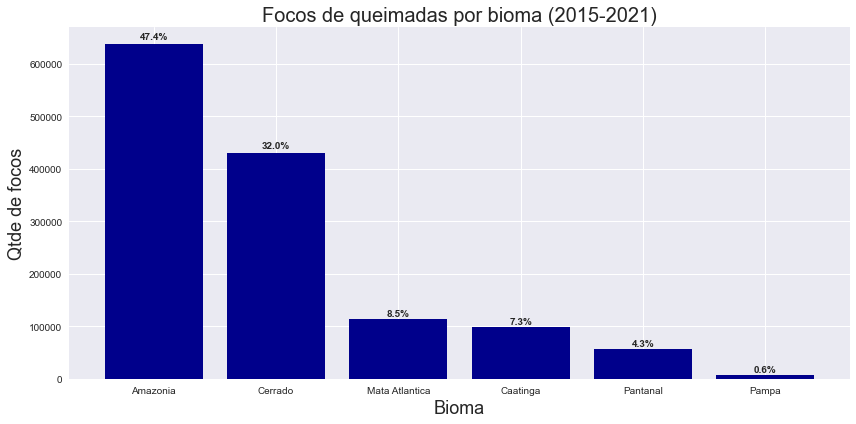

In [116]:
plt.figure(figsize=(12,6))
graph = plt.bar(df_bioma.bioma, df_bioma.qtde_focos, color='darkblue')
plt.title('Focos de queimadas por bioma (2015-2021)', fontsize=20)
plt.ylabel('Qtde de focos', fontsize=18)
plt.xlabel('Bioma', fontsize=18)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+height*1.01, str(np.round(df_bioma.qtde_focos_relativa[i],1))+'%', weight='bold', ha='center', va='bottom')
    i+=1
plt.tight_layout()
#plt.show();
plt.savefig('dados/queimadas_bioma.png', dpi=300)

Os biomas mais afetados com as queimadas são a Amazônia e o Cerrado, que somados chegam a quase a 80% dos focos de queimadas no período estudado.

### Focos de queimadas: por nível do risco-fogo

Lembrando que o valor do risco de fogo, é o previsto para o dia da detecção do foco.

Segundo o portal de queimadas: No cálculo são utilizadas informações do tipo de vegetação, histórico da chuva nos últimos 120 dias, umidade relativa mínima e temperatura máxima, ambas à superfície. 

In [43]:
df_riscofogo_nivel = df_focos_queimadas.groupby(['riscofogo_nivel'], as_index = True)['datahora'].count().reset_index()
df_riscofogo_nivel.rename(columns = {'datahora':'qtde_focos'}, inplace = True)

df_riscofogo_nivel.sort_values(by=['qtde_focos'], ascending=False, inplace=True, ignore_index=True)

# criar coluna com qtde de focos relativa
df_riscofogo_nivel['qtde_focos_relativa'] = np.round(df_riscofogo_nivel['qtde_focos'] / sum(df_riscofogo_nivel['qtde_focos']), 4) * 100
df_riscofogo_nivel

,riscofogo_nivel,qtde_focos,qtde_focos_relativa
0,critico,724629,53.84
1,alto,212670,15.80
2,minimo,158768,11.80
3,medio,141319,10.50
4,baixo,101312,7.53
5,na,7185,0.53


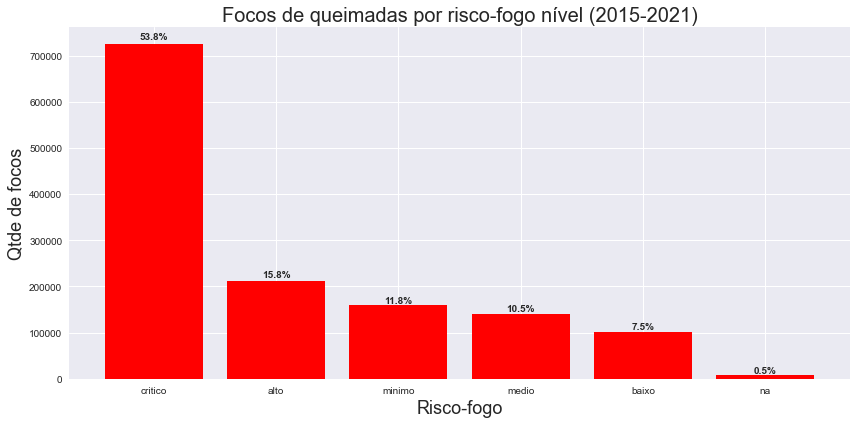

In [118]:
plt.figure(figsize=(12,6))
graph = plt.bar(df_riscofogo_nivel.riscofogo_nivel, df_riscofogo_nivel.qtde_focos, color='red')
plt.title('Focos de queimadas por risco-fogo nível (2015-2021)', fontsize=20)
plt.ylabel('Qtde de focos', fontsize=18)
plt.xlabel('Risco-fogo', fontsize=18)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+height*1.01, str(np.round(df_riscofogo_nivel.qtde_focos_relativa[i],1))+'%', weight='bold', ha='center', va='bottom')
    i+=1
plt.tight_layout()
plt.savefig('dados/queimadas_riscofogo.png', dpi=300)

### Focos de queimadas: por dias sem chuva

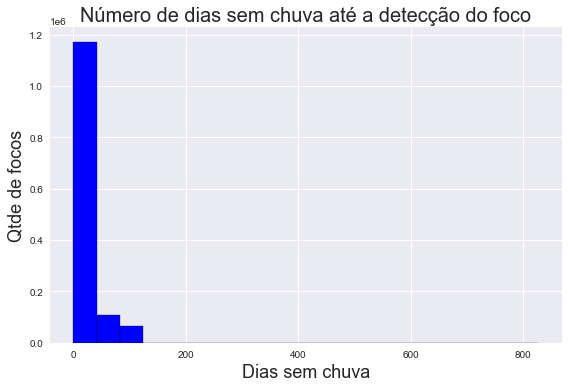

In [119]:
plt.hist(df_focos_queimadas['diasemchuva'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Dias sem chuva', fontsize=18)
plt.ylabel('Qtde de focos', fontsize=18)
plt.title('Número de dias sem chuva até a detecção do foco', fontsize=20)
plt.tight_layout()
plt.savefig('dados/queimadas_diassemchuva.png', dpi=300)
#plt.show();

A maior parte da distribuição do número de dias sem chuva até a detecção do foco está entre 0 a 50 dias.

### Focos de queimadas: por precipitação

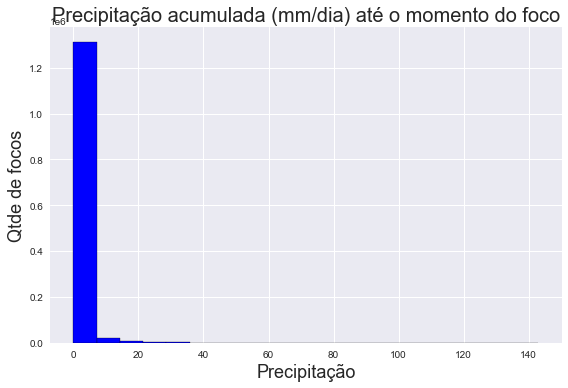

In [120]:
plt.hist(df_focos_queimadas['precipitacao'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Precipitação', fontsize=18)
plt.ylabel('Qtde de focos', fontsize=18)
plt.title('Precipitação acumulada (mm/dia) até o momento do foco', fontsize=20)
plt.tight_layout()
plt.savefig('dados/queimadas_precipitacao.png', dpi=300)
#plt.show();

A maior parte da distribuição de precipitação acumulada está entre 0 a 10 mm/dia, até o momento do foco.

### Focos de queimadas: por frp (Fire Radiative Power) em MW

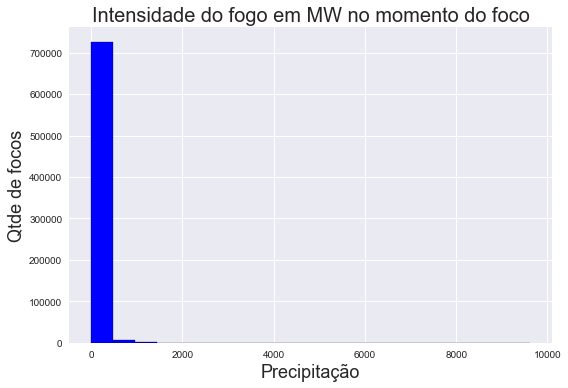

In [121]:
plt.hist(df_focos_queimadas['frp'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Precipitação', fontsize=18)
plt.ylabel('Qtde de focos', fontsize=18)
plt.title('Intensidade do fogo em MW no momento do foco', fontsize=20)
plt.tight_layout()
plt.savefig('dados/queimadas_frp.png', dpi=300)
#plt.show();

A maior parte da distribuição da intensidade do fogo (FRP), no momento do foco está entre 0 a 50 MW.

### Correlações


In [142]:
df_focos_queimadas2 = df_focos_queimadas.drop(
    ['municipio', 'latitude', 'longitude', 'dia_semana', 'datahora_tz','data','hora', 'ano'], axis=1)

In [143]:
_df1 = pd.get_dummies(df_focos_queimadas2['bioma'], prefix="bioma")
df_focos_queimadas2 = pd.concat([df_focos_queimadas2, _df1], axis=1)
df_focos_queimadas2.drop(['bioma'], axis=1, inplace=True)

In [144]:
corr = df_focos_queimadas2.corr()
corr.style.background_gradient(cmap='RdBu_r', axis=None)

,diasemchuva,precipitacao,riscofogo,frp,mes,riscofogo_categoria,bioma_Amazonia,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlantica,bioma_Pampa,bioma_Pantanal
diasemchuva,1.000000,-0.100668,0.013498,0.084263,-0.014608,0.295835,-0.241018,0.152926,0.229516,-0.068619,-0.030522,-0.025119
precipitacao,-0.100668,1.000000,-0.008553,-0.033025,0.007544,-0.269572,0.124345,-0.047629,-0.078567,-0.034123,-0.012803,-0.012615
riscofogo,0.013498,-0.008553,1.000000,0.015987,0.036350,0.115333,0.020434,0.011963,0.013657,-0.060144,-0.007950,-0.011553
frp,0.084263,-0.033025,0.015987,1.000000,0.039328,0.096234,-0.007783,0.001815,0.017663,-0.053361,-0.023353,0.053307
mes,-0.014608,0.007544,0.036350,0.039328,1.000000,0.012002,0.061294,0.124594,-0.061024,-0.102084,-0.062494,-0.006640
riscofogo_categoria,0.295835,-0.269572,0.115333,0.096234,0.012002,1.000000,-0.278420,0.149087,0.251913,-0.056087,-0.064850,0.016391
bioma_Amazonia,-0.241018,0.124345,0.020434,-0.007783,0.061294,-0.278420,1.000000,-0.266481,-0.650544,-0.288346,-0.073789,-0.200391
bioma_Caatinga,0.152926,-0.047629,0.011963,0.001815,0.124594,0.149087,-0.266481,1.000000,-0.192685,-0.085405,-0.021855,-0.059354
bioma_Cerrado,0.229516,-0.078567,0.013657,0.017663,-0.061024,0.251913,-0.650544,-0.192685,1.000000,-0.208495,-0.053354,-0.144897
bioma_Mata Atlantica,-0.068619,-0.034123,-0.060144,-0.053361,-0.102084,-0.056087,-0.288346,-0.085405,-0.208495,1.000000,-0.023649,-0.064224


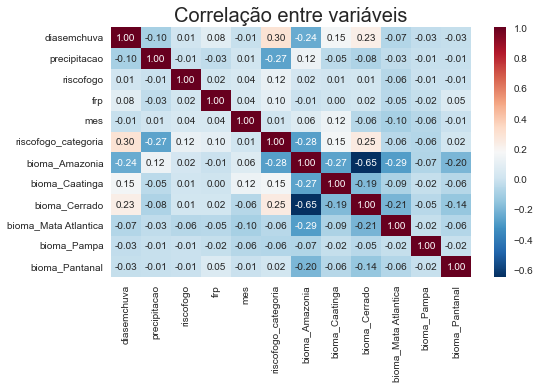

In [145]:
sns.heatmap(corr, annot = True, fmt = '.2f', cmap='RdBu_r')
plt.title('Correlação entre variáveis', fontsize=20)
plt.tight_layout()
plt.savefig('dados/queimadas_correlacao.png', dpi=300);
#plt.show()

Olhando para as correlações entre duas variáveis, nenhuma delas tem valores muito próximos de -1 ou 1, logo, não são correlações fortes. Mas mesmo assim, conseguimos ver correlações fracas da precipitação e os dias sem chuva que apontam alguma relação com o riscofogo_categoria.

Também é possível observar relação de alguns biomas com os dias sem chuva e o risco fogo.

#### Medir importância de algumas variáveis

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [188]:
df_focos_queimadas_imp = df_focos_queimadas.drop(
    ['municipio', 'latitude', 'longitude', 'dia_semana', 'datahora_tz','data','hora', 'ano'], axis=1)

In [189]:
df_focos_queimadas_imp['bioma'] = labelencoder.fit_transform(df_focos_queimadas_imp['bioma'])

df_focos_queimadas_imp.drop(['frp', 'estado', 'riscofogo', 'riscofogo_nivel'], axis=1, inplace=True)

In [191]:
df_focos_queimadas_imp.head()

,datahora,bioma,diasemchuva,precipitacao,mes,riscofogo_categoria
0,2015-11-07 16:30:00,0,4.0,0.1,11,0
1,2015-04-02 16:46:00,2,1.0,0.1,4,0
2,2015-03-23 17:47:00,0,3.0,0.4,3,0
3,2015-02-21 17:39:00,0,20.0,0.0,2,1
4,2015-08-02 17:25:00,0,0.0,0.1,8,1


In [ ]:
_X = df_focos_queimadas_imp.iloc[:, 1:-1]
_y = df_focos_queimadas_imp.iloc[:, -1:]

In [174]:
X_train, X_test, y_train, y_test = train_test_split(_X, _y, random_state=123)
model = RandomForestClassifier()
model.fit(X_train, y_train) 

# Importância das features
model.feature_importances_

C:\Users\ricardo.neves\AppData\Local\Temp\ipykernel_93504\1273796144.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


array([0.16623423, 0.38971819, 0.31374693, 0.13030066])

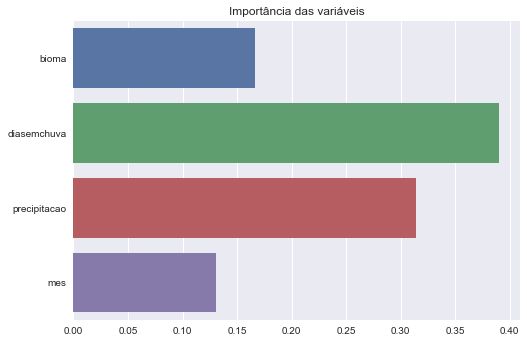

In [192]:
importances = pd.Series(data=model.feature_importances_, index=X_train.columns)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância das variáveis')
plt.savefig('dados/importancia.png', dpi=300)

<a id='l5'></a>

---

## Preparação de dados para o modelo

Será criada uma cópia do dataframe anterior para preparar os dados para os modelos de machine learning. O dataframe original, será utilizado para a exploração de dados.

In [193]:
df_focos_queimadas_ml = df_focos_queimadas.copy()

In [194]:
# Excluir colunas que não serão utilizadas

df_focos_queimadas_ml.drop(['datahora', 'datahora_tz', 'data', 'hora', 'latitude', 'longitude', 'municipio', 'estado'], axis=1, inplace=True)

In [195]:
# Transformar os níveis de fogo em ids

df_focos_queimadas_ml['riscofogo_nivel_id'] = labelencoder.fit_transform(df_focos_queimadas_ml['riscofogo_nivel'])

Transformar as colunas a seguir em colunas dummy, isso impede que elas sejam lidas pelo algoritmo como ordinais.

In [197]:
_df1 = pd.get_dummies(df_focos_queimadas_ml['bioma'], prefix="bioma", drop_first=True)
df_focos_queimadas_ml = pd.concat([df_focos_queimadas_ml, _df1], axis=1)

In [198]:
# Excluir colunas não utilizadas

df_focos_queimadas_ml.drop(['riscofogo_nivel', 'bioma'], axis=1, inplace=True)

In [199]:
df_focos_queimadas_ml.head()

,diasemchuva,precipitacao,riscofogo,frp,dia_semana,mes,ano,riscofogo_categoria,riscofogo_nivel_id,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlantica,bioma_Pampa,bioma_Pantanal
0,4.0,0.1,0.6,NaN,5,11,2015,0,3,0,0,0,0,0
1,1.0,0.1,0.3,NaN,3,4,2015,0,1,0,1,0,0,0
2,3.0,0.4,0.2,NaN,0,3,2015,0,1,0,0,0,0,0
3,20.0,0.0,1.0,NaN,5,2,2015,1,2,0,0,0,0,0
4,0.0,0.1,0.8,NaN,6,8,2015,1,0,0,0,0,0,0
